Epoch 1/500, Loss: 0.7220
Epoch 101/500, Loss: 0.0000
Epoch 201/500, Loss: 0.0000
Epoch 301/500, Loss: 0.0000
Epoch 401/500, Loss: 0.0000
Training Accuracy: 100.00%


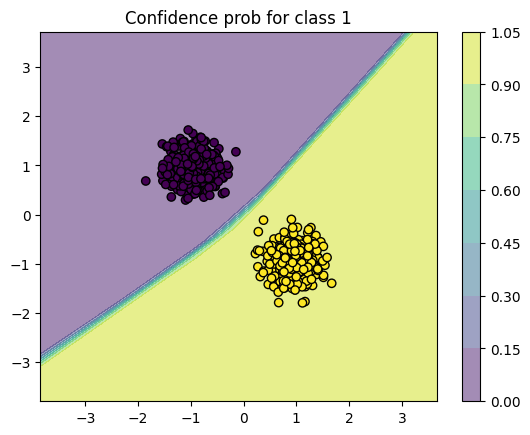

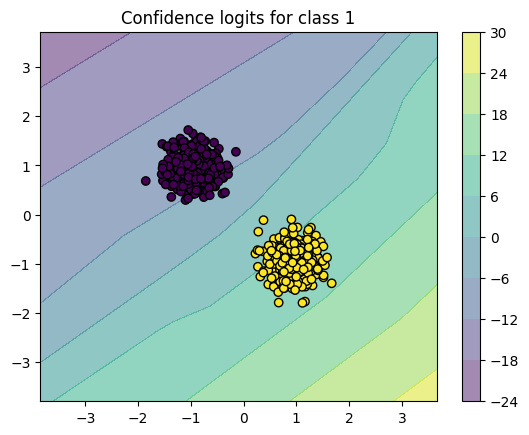

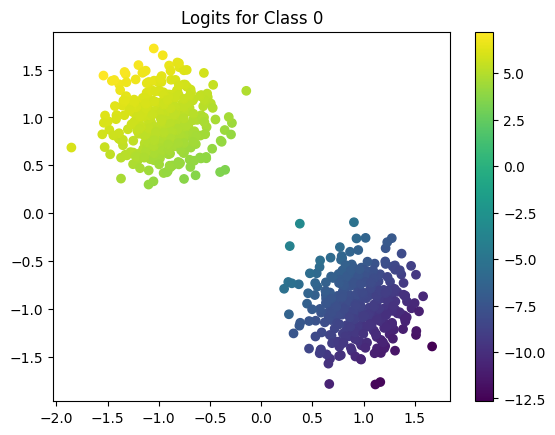

In [4]:
# Isotropic Gaussians
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
X, y = make_blobs(n_samples=1000, centers=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

# Our Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 2),
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
X_train = X_train.to(device)
y_train = y_train.to(device)

epochs = 500
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
# torch.save(model.state_dict(), 'GMMMLP-weights-isotropic.pth')

# Model Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_train)
    probabilities = nn.functional.softmax(logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    accuracy = (predictions == y_train).float().mean()
    print(f'Training Accuracy: {accuracy.item()*100:.2f}%')

# Decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        logits = model(grid)
        probs = nn.functional.softmax(logits, dim=1)
        Z = torch.argmax(probs, dim=1)
        # Z = probs
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()
    
def plot_confidence_prob(model, X, y):
    """Plots confidence score
    """
    cls = 1
    band = 2
    
    x_min, x_max = X[:, 0].min() - band, X[:, 0].max() + band
    y_min, y_max = X[:, 1].min() - band, X[:, 1].max() + band
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    grid = grid.to(device)
    with torch.no_grad():
        logits = model(grid)
        probs = nn.functional.softmax(logits, dim=1)
        Z = probs[:, cls]
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.5)
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(f"Confidence prob for class {cls}")
    plt.show()
    
def plot_confidence_logits(model, X, y):
    """Plots confidence score
    """
    cls = 1
    band = 2
    
    x_min, x_max = X[:, 0].min() - band, X[:, 0].max() + band
    y_min, y_max = X[:, 1].min() - band, X[:, 1].max() + band
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    grid = grid.to(device)
    with torch.no_grad():
        logits = model(grid)
        Z = logits[:, cls]
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.5)
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title(f"Confidence logits for class {cls}")
    plt.show()
    

# Converting for plotting
X_train_np = X_train.cpu().numpy()
y_train_np = y_train.cpu().numpy()

# Visualize DB
# plot_decision_boundary(model, X_train_np, y_train_np)
plot_confidence_prob(model, X_train_np, y_train_np)
plot_confidence_logits(model, X_train_np, y_train_np)

# Plot logits for class 0
plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=logits[:, 0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Logits for Class 0")
plt.show()


Epoch 1/500, Loss: 1.4024
Epoch 101/500, Loss: 0.0004
Epoch 201/500, Loss: 0.0003
Epoch 301/500, Loss: 0.0002
Epoch 401/500, Loss: 0.0001
Training Accuracy: 100.00%


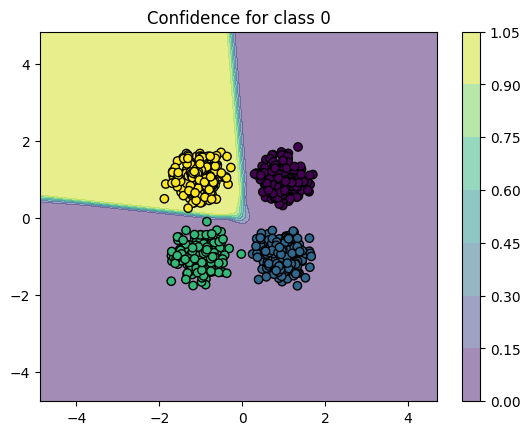

In [1]:
# non-isotropic Gaussians
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# Dataset
# X, y = make_blobs(n_samples=1000, centers=2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

gmm = GaussianMixture(n_components=4, covariance_type='full')
gmm.means_ = np.array([[-1, 1], [1, 1], [1, -1], [-1, -1]])
gmm.covariances_ = 0.4*np.array([[[0.2, 0], [0, 0.2]], 
                             [[0.2,0], [0,0.2]], 
                             [[0.2,0], [0,0.2]], 
                             [[0.2,0], [0,0.2]]])
gmm.weights_ = np.array([1/4, 1/4, 1/4, 1/4])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, y_train = gmm.sample(1000)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
# X_test = torch.FloatTensor(X_test)
# y_test = torch.LongTensor(y_test)

# Our Model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 10),
            nn.LeakyReLU(),
            nn.Linear(10, 4),
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
epochs = 500
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
# torch.save(model.state_dict(), 'GMMMLP-weights-isotropic-4-components.pth')


# Model Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_train)
    probabilities = nn.functional.softmax(logits, dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    accuracy = (predictions == y_train).float().mean()
    print(f'Training Accuracy: {accuracy.item()*100:.2f}%')

# Decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        logits = model(grid)
        probs = nn.functional.softmax(logits, dim=1)
        Z = torch.argmax(probs, dim=1)
        # Z = probs
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z.numpy(), alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()
    
def plot_confidence_prob(model, X, y):
    """Plots confidence score
    """
    cls = 0
    band = 3
    
    x_min, x_max = X[:, 0].min() - band, X[:, 0].max() + band
    y_min, y_max = X[:, 1].min() - band, X[:, 1].max() + band
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    with torch.no_grad():
        logits = model(grid)
        probs = nn.functional.softmax(logits, dim=1)
        Z = probs[:, cls]
        Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.5)
    plt.colorbar()
    plt.scatter(X[:, 0], X[:, 1], c=(y + 3) % 4, edgecolors='k')
    plt.title(f"Confidence for class {cls}")
    plt.show()

    

# Converting for plotting
X_train_np = X_train.cpu().numpy()
y_train_np = y_train.cpu().numpy()

# Visualize DB
# plot_decision_boundary(model, X_train_np, y_train_np)
plot_confidence_prob(model, X_train_np, y_train_np)

# Plot logits for class 0
# plt.scatter(X_train_np[:, 0], X_train_np[:, 1], c=logits[:, 0].cpu().numpy(), cmap='viridis')
# plt.colorbar()
# plt.title("Logits for Class 0")
# plt.show()
